<a href="https://colab.research.google.com/github/nhathpham/Taxi-Fleet-Management/blob/main/trip_cluster_NP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install hdbscan
#!pip install scikit-learn --upgrade

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from hdbscan import HDBSCAN
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.cluster import HDBSCAN
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
#import hdbscan
import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Mount Google Drive
drive.mount('/content/drive')

# Specify the path to your Parquet file
raw = pd.read_parquet('/content/drive/My Drive/USML Projects/Data/clean_data_0213.parquet')
len(raw)

In [ ]:
df = raw[raw['record_error'] == False]
df.shape

(1396117, 32)

# **A. Support Functions**

## 1. Determine best number of clusters


### 1.1 Elbow method (K-means only)

In [ ]:
def find_k_elbow(X, k_range):
    """
    Find the optimal number of clusters for KMeans using the Elbow Method.
    Parameters:
    - X: Preprocessed dataset
    - k_range: Range of k values to try (e.g., range(1, 11))
    Returns:
    - Optimal k value (elbow point) based on visual inspection
    """
    sse = []  # Sum of squared distances
    for k in k_range:
        print(k)
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        sse.append(kmeans.inertia_)  # Inertia: Sum of squared distances of samples to their closest cluster center

    plt.figure(figsize=(4, 3))
    plt.plot(k_range, sse, marker='o')
    plt.title('Elbow Method for Determining Optimal k')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Sum of squared distances')
    plt.xticks(k_range)
    plt.grid(False)
    plt.show()


### 1.2 Silhouette score (K-means, GMM, Hierarchical)

In [ ]:
# Sample a portion of the data because it takes a long time to run silhouette score on the whole dataset
def sample_dataset(X, sample_size):
    """
    Randomly sample a subset of the dataset.
    Parameters:
    - X: The dataset to be sampled (as a NumPy array or Pandas DataFrame).
    - sample_size: The size of the sample to take. If float, represents the fraction of the dataset to sample.
    Returns:
    - X_sample: A sampled subset of the dataset.
    """
    if isinstance(sample_size, float) and sample_size < 1.0:
        sample_size = int(len(X) * sample_size)
    if isinstance(X, pd.DataFrame):
        X_sample = X.sample(n=sample_size, random_state=42)
    else:  # assuming NumPy array
        indices = np.random.choice(len(X), size=sample_size, replace=False)
        X_sample = X[indices]
    return X_sample

In [ ]:
# higher = better
def find_k_sil_score(X, k_range, model_name, random_state):
    """
    Find the best number of clusters (k) for KMeans based on silhouette score and plot the silhouette scores.
    Parameters:
    - X: Preprocessed dataset
    - k_range: Range of k values to try (e.g., range(2, 11))

    Returns:
    - best_k: The number of clusters k that has the highest silhouette score.
    - silhouette_scores: A list of silhouette scores for each k in k_range.
    """
    silhouette_scores = []
    print("Calculating silhouette scores for different values of k...")
    for k in k_range:
        print(k)
        if model_name =='kmeans':
            model = KMeans(n_clusters=k, random_state=random_state)
        elif model_name =='GMM':
            model = GaussianMixture(n_components=k, random_state=random_state)
        else: #hierarchical
            model = AgglomerativeClustering(n_clusters=k)
        labels = model.fit_predict(X)
        score = silhouette_score(X, labels)
        silhouette_scores.append(score)
        #print(f"k = {k}: silhouette score = {score}")
    best_k = k_range[np.argmax(silhouette_scores)]

    # Plotting the silhouette scores
    plt.figure(figsize=(4, 3))
    plt.plot(k_range, silhouette_scores, marker='o', color='orange')
    plt.xlabel('k')
    plt.ylabel('Silhouette Score')
    plt.title(f'{model_name}: Silhouette Score by k')
    plt.xticks(k_range)
    plt.grid(False)
    plt.show()

    return best_k, silhouette_scores

### 1.3 BIC score (GMM)

In [ ]:
# lower = better
def find_k_gmm_bic(X, k_range, random_state):
    """
    Find the best number of components for GMM based on BIC.
    Parameters:
    - X: Preprocessed dataset
    - n_components_range: Range of n_components values to try
    Returns:
    - best_k: Optimal number of components with the lowest BIC
    """
    bic_scores = []
    for k in k_range:
        print(k)
        gmm = GaussianMixture(n_components=k, random_state=random_state)
        gmm.fit(X)
        bic_scores.append(gmm.bic(X))

    plt.figure(figsize=(4, 3))
    plt.plot(k_range, bic_scores, marker='o', color='blue')
    plt.title('GMM: BIC Score by k')
    plt.xlabel('k')
    plt.ylabel('BIC Score')
    plt.xticks(k_range)
    plt.grid(False)
    plt.show()

    best_k = k_range[np.argmin(bic_scores)]
    return best_k

## 2. K-means

In [ ]:
def apply_kmeans(X, n_clusters, random_state=42):
    """
    Apply KMeans clustering to the dataset.
    Parameters:
    - X: Preprocessed dataset
    - n_clusters: Optimal number of clusters determined previously
    Returns:
    - labels: Cluster labels for each data point
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    labels = kmeans.fit_predict(X)
    return kmeans, labels

In [ ]:
def evaluate_kmeans_init(X, n_clusters, random_states):
    """
    Evaluate KMeans clustering for different random states.

    Parameters:
    - X: Preprocessed dataset
    - n_clusters: Optimal number of clusters determined previously
    - random_states: A list of random states for initialization

    Returns:
    - evaluations: A list of dictionaries with each containing the random_state and silhouette_score
    """
    evaluations = []
    for rs in random_states:
        print("Random state:", rs)
        _, labels = apply_kmeans(X, n_clusters, rs)
        silhouette = silhouette_score(X, labels)

        evaluations.append({
            'random_state': rs,
            'silhouette_score': silhouette
        })

    return evaluations

## 3. GMM

In [ ]:
def apply_gmm(X, n_components, random_state=42):
    """
    Apply Gaussian Mixture Model clustering to the dataset.
    Parameters:
    - X: Preprocessed dataset
    - n_components: Optimal number of components determined previously
    Returns:
    - labels: Cluster labels for each data point
    """
    gmm = GaussianMixture(n_components=n_components, random_state=random_state)
    labels = gmm.fit_predict(X)
    p = gmm.predict_proba(X)
    return labels, p

In [ ]:
def evaluate_gmm_init(X, n_components, random_states):
    evaluations = []
    for rs in random_states:
        print(rs)
        labels, probabilities = apply_gmm(X, n_components, rs)
        assigned_probabilities = np.array([probabilities[i, label] for i, label in enumerate(labels)])
        avg_probability = np.mean(assigned_probabilities)
        # Need to refit GMM to compute AIC, BIC due to scikit-learn's API limitations
        gmm = GaussianMixture(n_components=n_components, random_state=rs).fit(X)
        aic = gmm.aic(X)
        bic = gmm.bic(X)
        #silhouette = silhouette_score(X, labels)

        evaluations.append({
            'random_state': rs,
            'average_probability': avg_probability,
            'aic': aic,
            'bic': bic,
            #'silhouette_score': silhouette
        })

    return evaluations

In [ ]:
def evaluate_gmm_init2(X, n_components_range, random_states):
    evaluations = []
    for n_components in n_components_range:
        for rs in random_states:
            print(f'Evaluating: n_components={n_components}, random_state={rs}')
            labels, probabilities = apply_gmm(X, n_components, rs)
            assigned_probabilities = np.array([probabilities[i, label] for i, label in enumerate(labels)])
            avg_probability = np.mean(assigned_probabilities)
            # Need to refit GMM to compute AIC, BIC due to scikit-learn's API limitations
            gmm = GaussianMixture(n_components=n_components, random_state=rs).fit(X)
            aic = gmm.aic(X)
            bic = gmm.bic(X)
            # silhouette = silhouette_score(X, labels)

            evaluations.append({
                'n_components': n_components,
                'random_state': rs,
                'average_probability': avg_probability,
                'aic': aic,
                'bic': bic,
                # 'silhouette_score': silhouette
            })

    return evaluations

## 4. Agglomerative Hierarchical

In [ ]:
def apply_agglomerative(X, n_clusters, metric, linkage):
    """
    Apply Agglomerative Hierarchical clustering to the dataset.
    Parameters:
    - X: Preprocessed dataset
    - n_clusters: Optimal number of clusters determined previously
    Returns:
    - labels: Cluster labels for each data point
    """
    agglomerative = AgglomerativeClustering(n_clusters=n_clusters, metric=metric, linkage=linkage)
    labels = agglomerative.fit_predict(X)
    return labels

In [ ]:
def evaluate_agg(X, n_clusters, metrics, linkages):
    """
    Evaluate Agglomerative Hierarchical clustering with different metrics and linkages.

    Parameters:
    - X: Preprocessed dataset
    - n_clusters: Number of clusters
    - metrics: List of metrics to compute the linkage
    - linkages: List of linkage criteria to use

    Returns:
    - A list of tuples containing (metric, linkage, silhouette score) for each combination
    - The best combination and its silhouette score
    """
    evaluation_results = []
    for metric in metrics:
        for linkage in linkages:
            # 'ward' linkage only works with 'euclidean' metric
            if linkage == 'ward' and metric != 'euclidean':
                continue
            labels = apply_agglomerative(X,n_clusters=n_clusters, metric=metric, linkage=linkage)
            score = silhouette_score(X, labels, metric=metric)
            evaluation_results.append((metric, linkage, score))

    # Identify the best combination
    best_combination = max(evaluation_results, key=lambda x: x[2])
    return evaluation_results, best_combination

In [ ]:

from collections import Counter

def cluster_balance(labels):
    """Calculate a balance score for clusters, lower is better."""
    cluster_sizes = Counter(labels)
    max_size = max(cluster_sizes.values())
    min_size = min(cluster_sizes.values())
    # Simple balance metric: ratio of sizes of the smallest to the largest cluster
    balance = min_size / max_size
    return balance

def evaluate_with_balance(X, n_clusters, metrics, linkages):
    best_score = -1
    best_combination = None
    best_balance = 0
    for metric in metrics:
        for linkage in linkages:
            if linkage == 'ward' and metric != 'euclidean':
                continue
            labels = apply_agglomerative(X, n_clusters, metric, linkage)
            score = silhouette_score(X, labels)
            balance = cluster_balance(labels)
            # Consider both silhouette score and balance; adjust weighting as needed
            combined_score = score * balance  # Example of combining the two criteria
            if combined_score > best_score or (combined_score == best_score and balance > best_balance):
                best_score = combined_score
                best_combination = (metric, linkage)
                best_balance = balance
    return best_combination, best_score, best_balance

## 5. HDBSCAN

In [ ]:
def apply_hdbscan(X, min_cluster_size=15, metric = 'euclidean', algorithm = 'auto', min_samples=None):
    """
    Apply HDBSCAN clustering to the dataset.
    Parameters:
    - X: Preprocessed dataset
    - min_cluster_size: The minimum size of clusters; smaller clusters will be considered noise.
    - min_samples: The number of samples in a neighborhood for a point to be considered a core point. If none, set to min_cluster_size
    Returns:
    - labels: Cluster labels for each data point
    """
    clusterer = HDBSCAN(min_cluster_size=min_cluster_size,
                                min_samples=min_samples,
                                metric=metric,
                                algorithm=algorithm,
                                cluster_selection_method='eom')
    labels = clusterer.fit_predict(X)
    return labels

## 6. Cluster EDA

In [ ]:
def boxplot(df, cluster_col, col_name, title, ylabel=None, show_outliers=False):
    plt.figure(figsize=(4, 2))
    sns.boxplot(x=cluster_col, y=col_name, data=df, showfliers=show_outliers)
    plt.title(title)
    plt.xlabel('Cluster')
    if ylabel==None:
      plt.ylabel(col_name)
    plt.ylabel(ylabel)
    plt.show()

In [ ]:
def compare_table(df,cluster_col):
  display(df.groupby(cluster_col)[region_cols].median())
  display(df.groupby(cluster_col)[time_cols].median())
  display(df.groupby(cluster_col)[pay_cols].median())
  display(df.groupby(cluster_col)[['daily_payment','daily_miles']].median())
  display(df.groupby(cluster_col)[['ct_pickup_ca','ct_dropoff_ca']].median())
  #display(df.groupby(cluster_col)[['median_pct_tips']].median())
  #display(df.groupby(cluster_col)[['weekend_to_weekday_ratio']].median())
  display(df.groupby(cluster_col)[rev_cols].median())


In [ ]:
def top_ca_dict(df, group_col, value_cols, top_n):
    """
    Calculate the top N columns by median value for each group in a DataFrame,
    including the median values, with simplified column names.

    Parameters:
    - df: DataFrame to process.
    - group_col: Column name to group by.
    - value_cols: List of columns to calculate medians for.
    - top_n: Number of top columns to return for each group, including their median values.

    Returns:
    - A dictionary with the top N columns (with simplified names) and their median values for each group.
    """
    # Calculate medians for each group
    median_df = df.groupby(group_col)[value_cols].median()

    # Define the prefix to remove
    prefix_to_remove = 'pickup_ca_name_'

    # For each cluster, find the top N columns by median value and include those values
    top_columns = {}
    for cluster in median_df.index:
        top_vals = median_df.loc[cluster].nlargest(top_n)
        # Simplify column names by removing the specified prefix and replace it with nothing
        simplified_names = {col.replace(prefix_to_remove, ''): val for col, val in top_vals.items()}
        top_columns[cluster] = simplified_names
    return top_columns

In [ ]:
# Function to create bar graphs for each cluster's top 10 CA columns with the same x-axis range
def plot_top_ca(ca_top_dict, max_value):
    for cluster, ca_dict in ca_top_dict.items():
        # Prepare data for plotting
        ca_names = list(ca_dict.keys())
        ca_values = list(ca_dict.values())

        # Create bar graph
        plt.figure(figsize=(5, 3))
        plt.barh(ca_names, ca_values, color='skyblue')
        plt.xlabel('Median Value')
        plt.ylabel('Community Area')
        plt.title(f'Top 10 Community Areas for Cluster {cluster}')
        plt.xlim(0, max_value)  # Set the same x-axis range for all plots
        plt.gca().invert_yaxis()  # Invert y-axis to have the highest value on top
        plt.show()

In [ ]:
def plot_top_ca_1c(ca_top_dict, cluster, max_value, title, xlabel, ylabel):
    # Get the CA dictionary for the specified cluster
    ca_dict = ca_top_dict.get(cluster, None)
    if ca_dict is None:
        print(f"No data found for cluster {cluster}")
        return

    # Prepare data for plotting
    ca_names = list(ca_dict.keys())
    ca_values = list(ca_dict.values())

    # Create bar graph
    plt.figure(figsize=(4, 2))
    bars = plt.barh(ca_names, ca_values, color='skyblue')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim(0, max_value+0.08)  # Set the same x-axis range for all plots
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest value on top

    for bar, value in zip(bars, ca_values):
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{value:.2f}',
                 va='center', ha='left', color='black')
    plt.show()

In [ ]:
import matplotlib.colors as mcolors

def triptotal_hist(cluster_col):
  # Get unique clusters and weekend values
  clusters = df[cluster_col].unique()
  weekend_values = df['is_weekend'].unique()
  cmap = plt.get_cmap('Greens')

  # Find overall minimum and maximum 'trip_total' values
  overall_min = df['trip_total'].min()
  overall_max = df['trip_total'].max()

  for cluster in clusters:
      fig, axs = plt.subplots(1, len(weekend_values), figsize=(len(weekend_values) * 5, 3))
      for i, is_weekend in enumerate(weekend_values):
          filtered_data = df[(df[cluster_col] == cluster) & (df['is_weekend'] == is_weekend)]
          n, bins, patches = axs[i].hist(filtered_data['trip_total'], bins=30, edgecolor='black')
          fracs = n / n.max()
          norm = mcolors.Normalize(fracs.min(), fracs.max())
          for thisfrac, thispatch in zip(fracs, patches):
              color = cmap(norm(thisfrac))
              thispatch.set_facecolor(color)
          axs[i].set_title(f'Cluster {cluster} - {"Weekend" if is_weekend else "Weekday"}')
          axs[i].set_xlabel('Trip Total')
          axs[i].set_ylabel('Frequency')
          axs[i].set_xlim(overall_min, overall_max)  # Set same x-axis limits for all subplots
      plt.tight_layout()
      plt.show()


def timeofday(cluster_col):
    # Code visualizes the number of trips for each 'period_start' in each cluster
    period_order = ['Early Morning', 'Morning Rush', 'Midday', 'Afternoon', 'Evening Rush', 'Evening', 'Night']
    colors = plt.cm.get_cmap('Set2', len(period_order))
    clusters = df_final[cluster_col].unique()

    for cluster in clusters:
        filtered_data = df_final[df_final[cluster_col] == cluster]
        grouped_data = filtered_data.groupby('period_start')
        period_start_counts = grouped_data.size().reindex(period_order)

        plt.figure(figsize=(4, 3))
        plt.bar(period_start_counts.index, period_start_counts.values, color = colors(1), width=0.4)
        plt.title(f'Trips Count by Time of Day - {cluster}')
        plt.xlabel('')
        plt.ylabel('Trip Count')
        plt.xticks(rotation=30)
        plt.tight_layout()
        plt.show()


def toparea_bar(cluster_col):
  #Code groups the data by 'kmeans_cluster_labels', creates subplots for each cluster, and plots the top 10 pickup and dropoff locations for each cluster.
  grouped_data = df.groupby(cluster_col)
  num_clusters = len(grouped_data)
  fig, axs = plt.subplots(num_clusters, 2, figsize=(10, num_clusters*3 ))

  for i, (cluster_label, group) in enumerate(grouped_data):
      pickup_counts = group['pickup_ca_name'].value_counts()
      dropoff_counts = group['dropoff_ca_name'].value_counts()
      top_pickups = pickup_counts.head()
      top_dropoffs = dropoff_counts.head(10)
      axs[i, 0].barh(top_pickups.index, top_pickups.values, color='skyblue')
      axs[i, 0].set_title(f'Top 10 Pickup Locations - Cluster {cluster_label}')
      axs[i, 0].set_xlabel('Number of Trips')
      axs[i, 0].set_ylabel('Pickup Location')
      axs[i, 1].barh(top_dropoffs.index, top_dropoffs.values, color='salmon')
      axs[i, 1].set_title(f'Top 10 Dropoff Locations - Cluster {cluster_label}')
      axs[i, 1].set_xlabel('Number of Trips')
      axs[i, 1].set_ylabel('Dropoff Location')

  plt.tight_layout()
  plt.show()


def top_route(cluster_col):
    # Code groups the data by 'kmeans_cluster_labels', creates subplots for each cluster, and plots the top 10 pickup-dropoff combinations for each cluster.
    grouped_data = df.groupby(cluster_col)
    num_clusters = len(grouped_data)
    fig, axs = plt.subplots(num_clusters, figsize=(5, num_clusters * 3))

    for i, (cluster_label, group) in enumerate(grouped_data):
        pickup_dropoff = group['pickup_ca_name'] + ' -> ' + group['dropoff_ca_name']
        pickup_dropoff_counts = pickup_dropoff.value_counts()
        top_pickup_dropoffs = pickup_dropoff_counts.head(10)

        # Get x and y coordinates for scatter plot
        y = range(len(top_pickup_dropoffs))
        x = top_pickup_dropoffs.values

        axs[i].scatter(x, y, color='green')  # Scatter plot instead of bar chart
        axs[i].set_yticks(y)
        axs[i].set_yticklabels(top_pickup_dropoffs.index)  # Use route names as y-axis labels
        axs[i].set_title(f'Top 10 Routes - {cluster_label}')
        axs[i].set_xlabel('Trip Count')
        axs[i].set_ylabel('')

    plt.tight_layout()
    plt.show()

def plot_cluster_pickup_dropoff_means(df, cluster_col): #gmm
    # Determine the axis limits
    x_min = min(df['pickup_longitude'].min(), df['dropoff_longitude'].min()) - 0.01
    x_max = max(df['pickup_longitude'].max(), df['dropoff_longitude'].max()) + 0.01
    y_min = min(df['pickup_latitude'].min(), df['dropoff_latitude'].min()) - 0.01
    y_max = max(df['pickup_latitude'].max(), df['dropoff_latitude'].max()) + 0.01

    # Create a scatter plot for each cluster
    for cluster in sorted(df[cluster_col].unique()):
        fig, axs = plt.subplots(1, 2, figsize=(7, 3), sharey=True, sharex=True)

        # Filter the DataFrame for the current cluster
        cluster_data = df[df[cluster_col] == cluster]

        # Plot pickup points on the first subplot
        axs[0].scatter(cluster_data['pickup_longitude'], cluster_data['pickup_latitude'],
                       c='blue', alpha=0.3, marker='o', s=10, label='Pickup')
        axs[0].set_title(f'Pickup Areas - {cluster}')
        axs[0].set_xlabel('lon')
        axs[0].set_ylabel('lat')
        axs[0].grid(alpha=0.3)

        # Plot dropoff points on the second subplot
        axs[1].scatter(cluster_data['dropoff_longitude'], cluster_data['dropoff_latitude'],
                       c='orange', alpha=0.3, marker='x', s=10, label='Dropoff')
        axs[1].set_title(f'Dropoff Areas - {cluster}')
        axs[1].set_xlabel('lon')
        axs[1].grid(alpha=0.3)

        # Set the same limits for x and y axis
        axs[0].set_xlim(x_min, x_max)
        axs[0].set_ylim(y_min, y_max)

        # Show the plot
        plt.show()

def boxplot2(df, cluster_col, col_name, title, ylabel=None, show_outliers=False):
    # Set up subplots
    fig, axes = plt.subplots(1, len(df[cluster_col].unique()), figsize=(15, 4), sharey=True)

    # Iterate over clusters
    for i, cluster in enumerate(df[cluster_col].unique()):
        # Filter data for the current cluster
        cluster_data = df[df[cluster_col] == cluster]

        # Plot boxplot for weekdays
        sns.boxplot(x='is_weekend', y=col_name, data=cluster_data, ax=axes[i], showfliers=show_outliers)
        axes[i].set_title(f'Cluster {cluster}')
        axes[i].set_xlabel('Weekday/Weekend')
        if ylabel is not None:
            axes[i].set_ylabel(ylabel)
        axes[i].set_xticklabels(['Weekday', 'Weekend'])  # Set x-axis labels

    # Set title
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


# **B. Filter data (baseline and outlier removed)**

In [ ]:
# Assuming df is your pandas DataFrame with the 'median_idle_seconds' column
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.15)
    Q3 = df[column].quantile(0.85)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    #print(lower_bound)
    #print(upper_bound)
    # Filter out the outliers
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return filtered_df

In [ ]:
#Selecting the above mentioned features for addressing this problem
df = df[df.dropoff_latitude.notna()]
df_final = df[['pickup_latitude', 'pickup_longitude','dropoff_latitude','dropoff_longitude','period_start','is_weekend','trip_total']]
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1298323 entries, 0 to 1597811
Data columns (total 7 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   pickup_latitude    1298323 non-null  float64
 1   pickup_longitude   1298323 non-null  float64
 2   dropoff_latitude   1298323 non-null  float64
 3   dropoff_longitude  1298323 non-null  float64
 4   period_start       1298323 non-null  object 
 5   is_weekend         1298323 non-null  int64  
 6   trip_total         1298323 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 79.2+ MB


# **C. Clustering models**

## 1. Feature scaling

In [ ]:
from sklearn.preprocessing import RobustScaler
categorical_features = ['period_start']

# Update your preprocessor to include the RobustScaler for the numeric feature
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features)#,
    ],
    remainder='passthrough'
)
X = preprocessor.fit_transform(df_final)

## 2. Run KMeans

### 2.1 Choose k

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


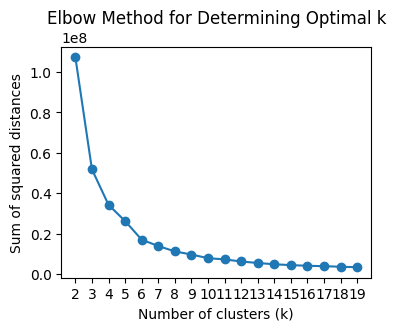

In [ ]:
# Choose K
# Elbow method
find_k_elbow(X, range(2, 20))

Calculating silhouette scores for different values of k...
2
3
4
5
6
7
8
9
10


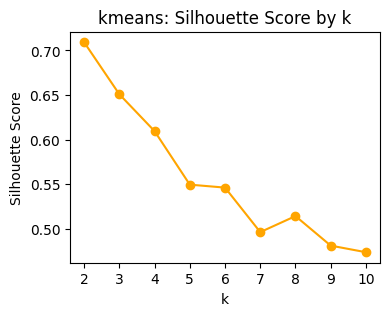

In [ ]:
# Silhouette score on sample data
sample_size = 0.01  # 5% of dataset = 75,000
X_sample = sample_dataset(X, sample_size)
# Silhouette score
best_k, silhouette_scores = find_k_sil_score(X_sample, range(2, 11), model_name='kmeans', random_state=42)


### 2.2 Run models

In [ ]:
best_k = 3
kmeans, labels = apply_kmeans(X, best_k, random_state=131)
df['cluster_kmeans'] = labels
df['cluster_kmeans'].value_counts()

0    690040
1    332293
2    275990
Name: cluster_kmeans, dtype: int64

### 2.3 Cluster EDAs

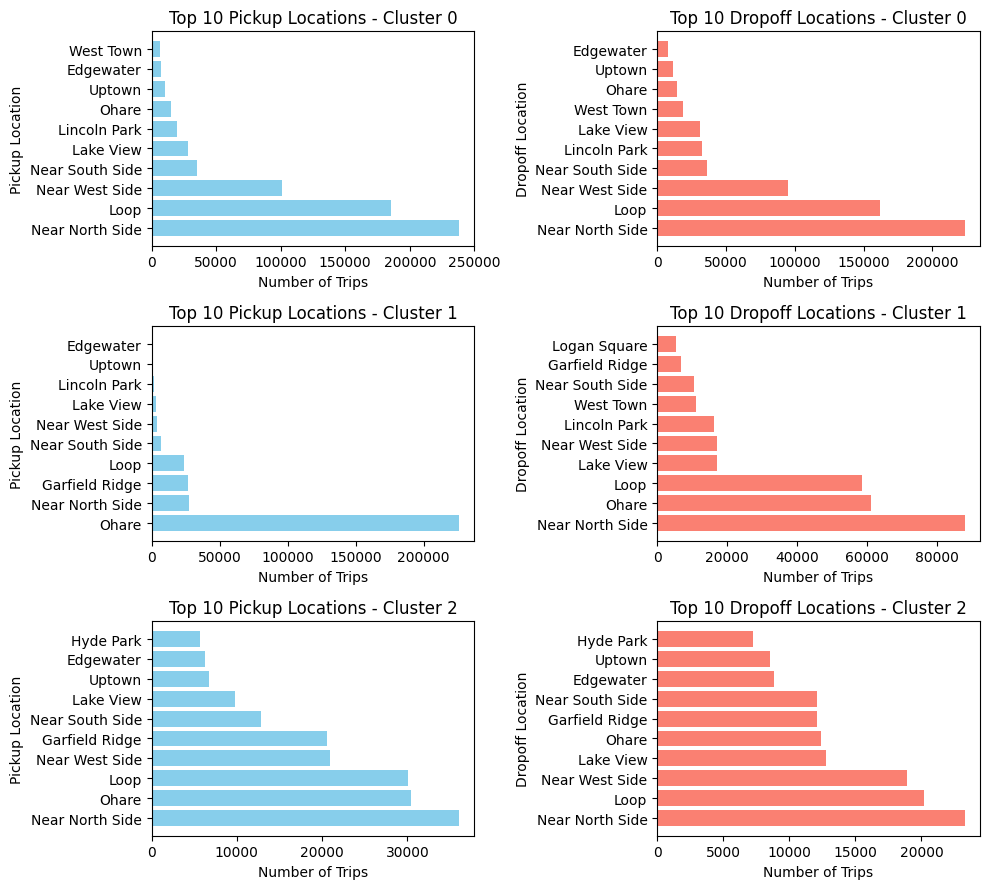

In [ ]:
#Code groups the data by 'kmeans_cluster_labels', creates subplots for each cluster, and plots the top 10 pickup and dropoff locations for each cluster.
grouped_data = df.groupby('cluster_kmeans')
num_clusters = len(grouped_data)
fig, axs = plt.subplots(num_clusters, 2, figsize=(10, num_clusters*3 ))

for i, (cluster_label, group) in enumerate(grouped_data):
    pickup_counts = group['pickup_ca_name'].value_counts()
    dropoff_counts = group['dropoff_ca_name'].value_counts()
    top_pickups = pickup_counts.head()
    top_dropoffs = dropoff_counts.head(10)
    axs[i, 0].barh(top_pickups.index, top_pickups.values, color='skyblue')
    axs[i, 0].set_title(f'Top 10 Pickup Locations - Cluster {cluster_label}')
    axs[i, 0].set_xlabel('Number of Trips')
    axs[i, 0].set_ylabel('Pickup Location')
    axs[i, 1].barh(top_dropoffs.index, top_dropoffs.values, color='salmon')
    axs[i, 1].set_title(f'Top 10 Dropoff Locations - Cluster {cluster_label}')
    axs[i, 1].set_xlabel('Number of Trips')
    axs[i, 1].set_ylabel('Dropoff Location')

plt.tight_layout()
plt.show()

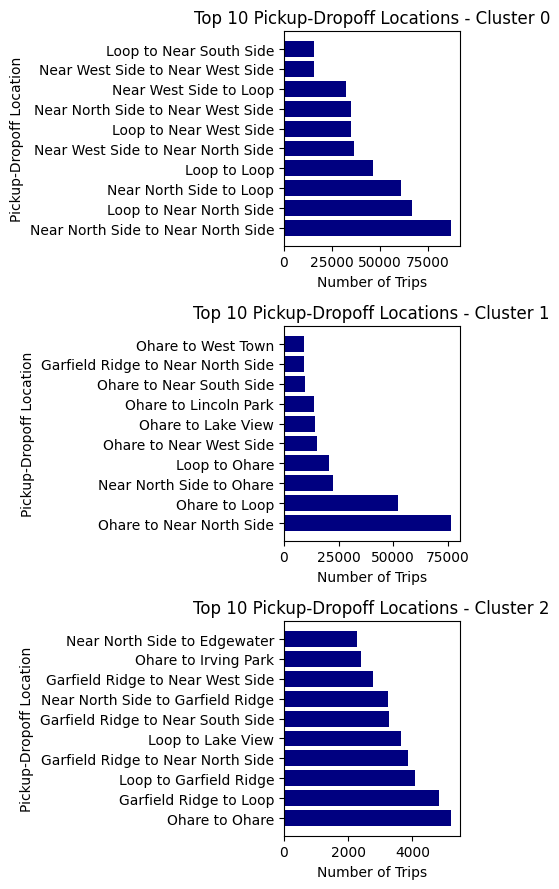

In [ ]:
#Code groups the data by 'kmeans_cluster_labels', creates subplots for each cluster, and plots the top 10 pickup-dropoff combinations for each cluster.
grouped_data = df.groupby('cluster_kmeans')
num_clusters = len(grouped_data)
fig, axs = plt.subplots(num_clusters, figsize=(5, num_clusters * 3))

for i, (cluster_label, group) in enumerate(grouped_data):
    pickup_dropoff = group['pickup_ca_name'] + ' to ' + group['dropoff_ca_name']
    pickup_dropoff_counts = pickup_dropoff.value_counts()
    top_pickup_dropoffs = pickup_dropoff_counts.head(10)
    axs[i].barh(top_pickup_dropoffs.index, top_pickup_dropoffs.values, color='navy')
    axs[i].set_title(f'Top 10 Pickup-Dropoff Locations - Cluster {cluster_label}')
    axs[i].set_xlabel('Number of Trips')
    axs[i].set_ylabel('Pickup-Dropoff Location')

plt.tight_layout()
plt.show()

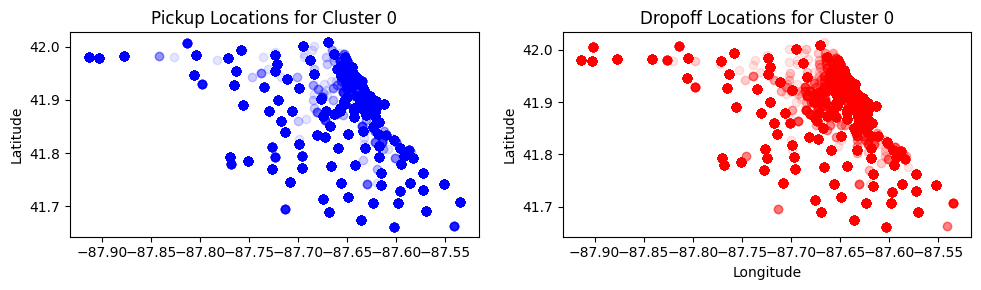

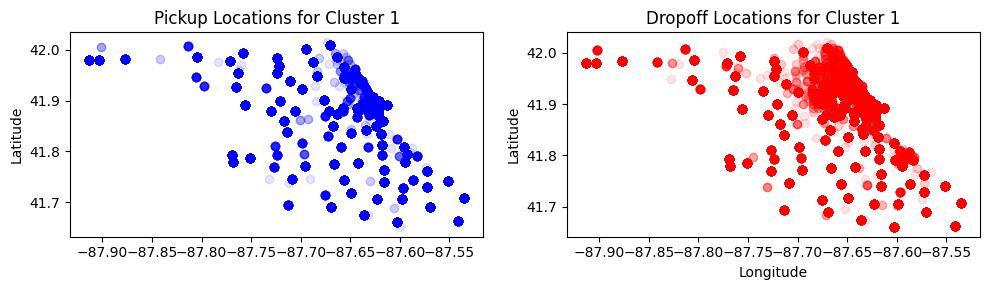

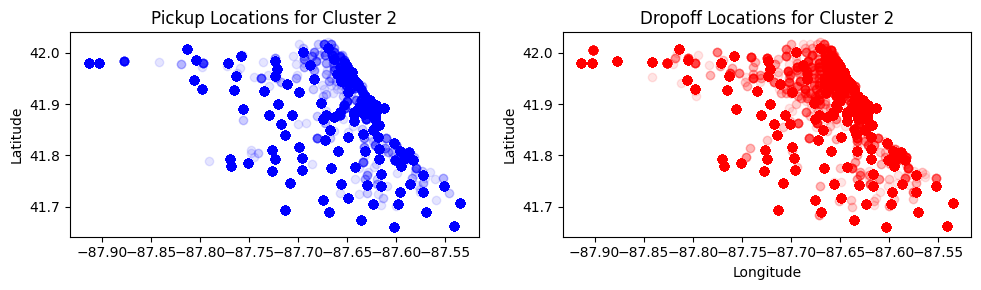

In [ ]:
# Get unique cluster labels
unique_clusters = np.unique(df['cluster_kmeans'])

# Loop through each cluster to create separate figures
for cluster in unique_clusters:
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))

    # Filter data for the current cluster
    cluster_data = df[df['cluster_kmeans'] == cluster]

    # Scatter plot for pickup locations
    axs[0].scatter(cluster_data['pickup_longitude'], cluster_data['pickup_latitude'], c='blue', alpha=0.1)
    axs[0].set_ylabel('Latitude')
    axs[0].set_title(f'Pickup Locations for Cluster {cluster}')

    # Scatter plot for dropoff locations
    axs[1].scatter(cluster_data['dropoff_longitude'], cluster_data['dropoff_latitude'], c='red', alpha=0.1)
    axs[1].set_xlabel('Longitude')
    axs[1].set_ylabel('Latitude')
    axs[1].set_title(f'Dropoff Locations for Cluster {cluster}')

    plt.tight_layout()
    plt.show()


## 3. Run GMM

### 3.1 Choose n

2
3
4
5
6
7
8
9
10
11
12


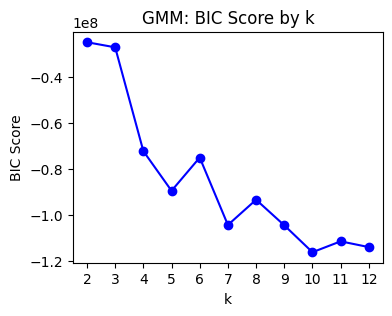

10

In [ ]:
# Silhouette score (higher = better)
#best_k, silhouette_scores = find_k_sil_score(X_op_base, range(2, 20), model_name='gmm', random_state=2021)
# BIC (lower = better)
find_k_gmm_bic(X, range(2, 13), random_state=3242)

### 3.2 Find best initialization

In [ ]:
# Pick the best random state

# Range of n_components to try
n_components_range = [4, 5, 6, 7]  # Example component range
random_states = [42, 739, 2021, 1]
evaluations = evaluate_gmm_init2(X, n_components_range, random_states)

# Analyzing results to find the best model based on BIC
best_by_bic = min(evaluations, key=lambda x: x['bic'])
print("Best model by BIC:", best_by_bic)

Evaluating: n_components=4, random_state=42
Evaluating: n_components=4, random_state=739
Evaluating: n_components=4, random_state=2021
Evaluating: n_components=4, random_state=1
Evaluating: n_components=5, random_state=42
Evaluating: n_components=5, random_state=739
Evaluating: n_components=5, random_state=2021
Evaluating: n_components=5, random_state=1
Evaluating: n_components=6, random_state=42
Evaluating: n_components=6, random_state=739
Evaluating: n_components=6, random_state=2021
Evaluating: n_components=6, random_state=1
Evaluating: n_components=7, random_state=42
Evaluating: n_components=7, random_state=739
Evaluating: n_components=7, random_state=2021
Evaluating: n_components=7, random_state=1
Best model by BIC: {'n_components': 7, 'random_state': 42, 'average_probability': 0.9926869711086835, 'aic': -93385855.58422847, 'bic': -93376991.37158005}


In [ ]:
random_states = [92, 14, 89, 30]

evaluations5 = evaluate_gmm_init(X, 5, random_states)

# Analyzing results to find the best model based on BIC
best_by_bic = min(evaluations5, key=lambda x: x['bic'])
print("Best model by BIC:", best_by_bic)

92
14


KeyboardInterrupt: 

### 3.3 Run GMM

In [ ]:
n_components = 5
labels, p = apply_gmm(X, n_components=n_components, random_state=739) #  #10 #2021
df['cluster_gmm5'] = labels
df_final['cluster_gmm5'] = labels
df_final.groupby('cluster_gmm5').size()

cluster_gmm5
0    336467
1    215376
2    324285
3    269255
4    152940
dtype: int64

### 3.4 Cluster EDA

In [ ]:
df_final.cluster_gmm5.value_counts()

0    336467
2    324285
3    269255
1    215376
4    152940
Name: cluster_gmm5, dtype: int64

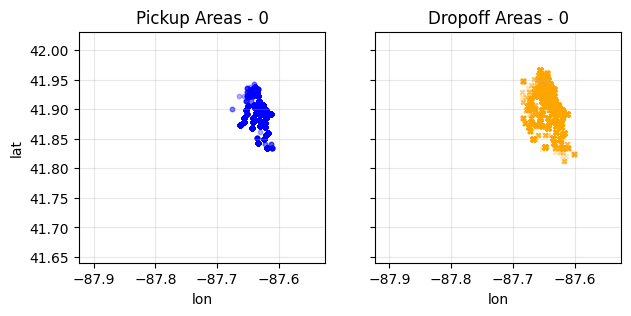

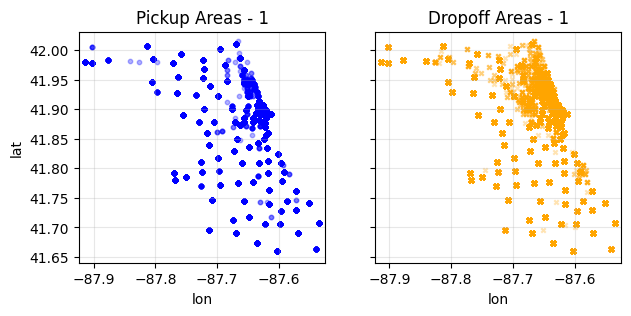

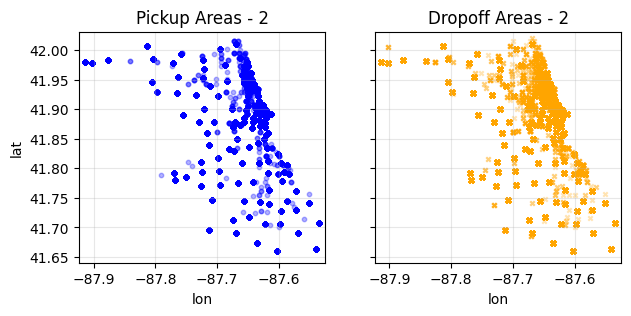

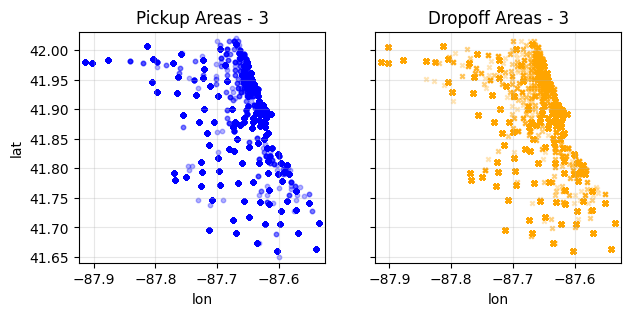

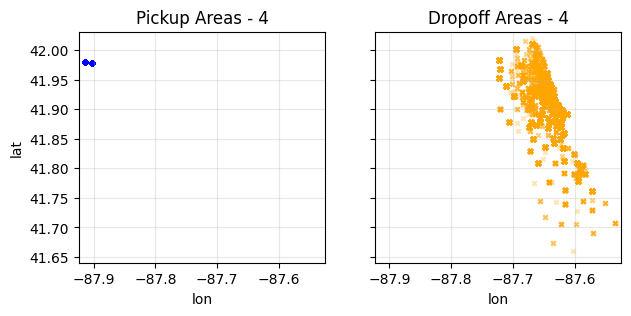

In [ ]:
plot_cluster_pickup_dropoff_means(df_final, 'cluster_gmm5')

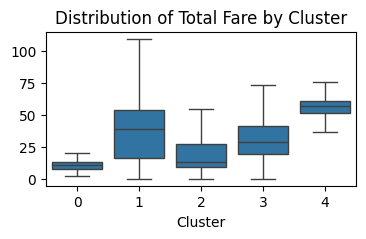

In [ ]:
boxplot(df, 'cluster_gmm5', 'trip_total', title='Distribution of Total Fare by Cluster',ylabel='', show_outliers=False)
#boxplot2(df, 'cluster_gmm5', 'trip_total', title='Distribution of Total Fare by Cluster',ylabel='', show_outliers=False)

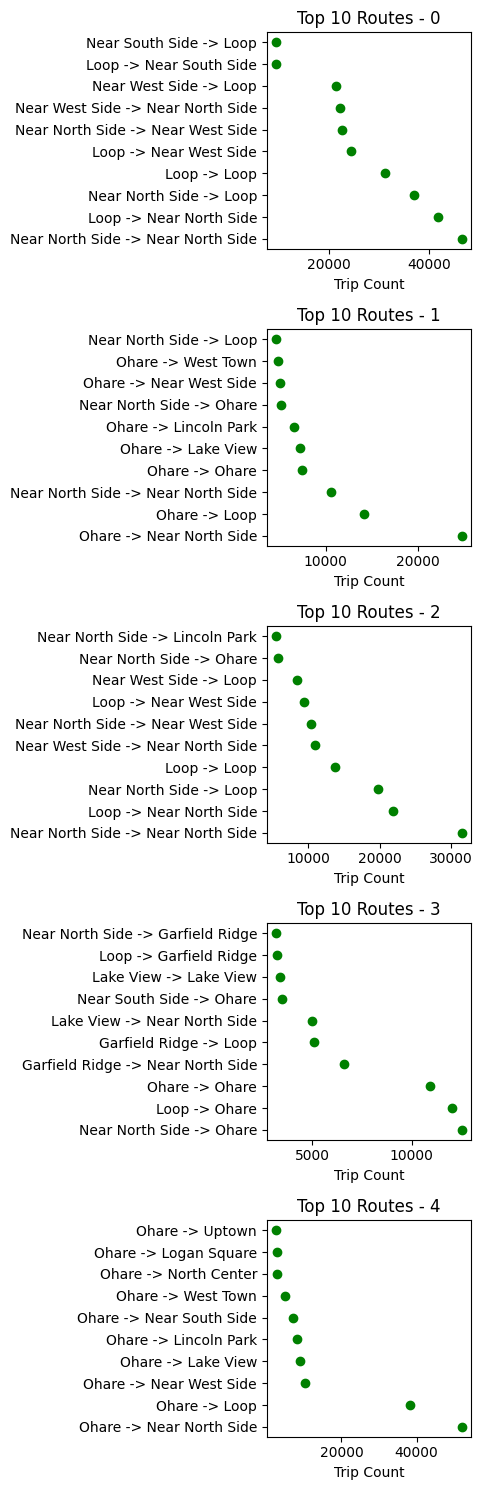

In [ ]:
top_route('cluster_gmm5')

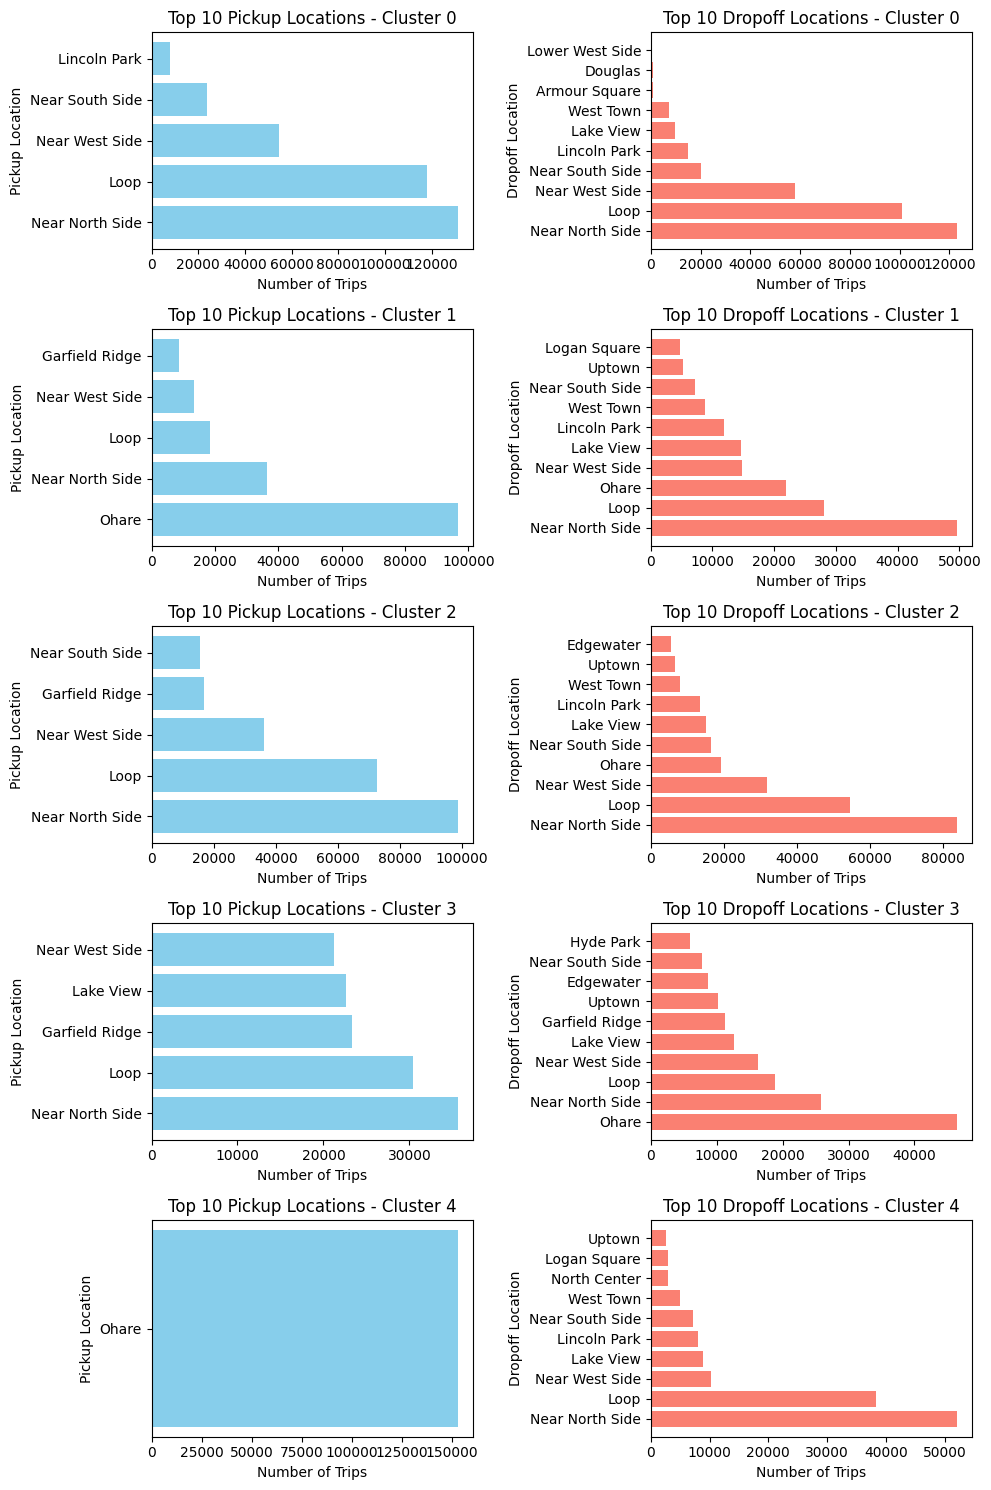

In [ ]:
toparea_bar('cluster_gmm5')

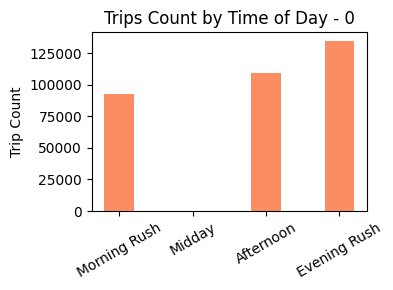

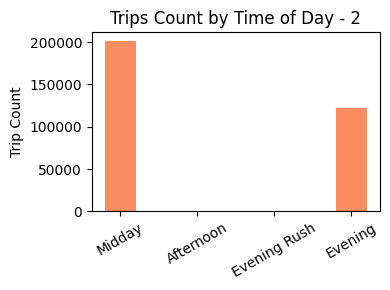

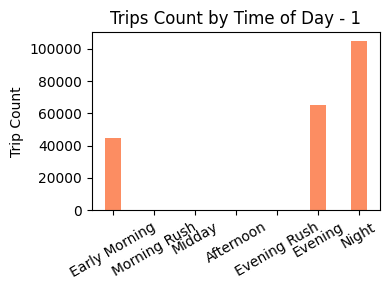

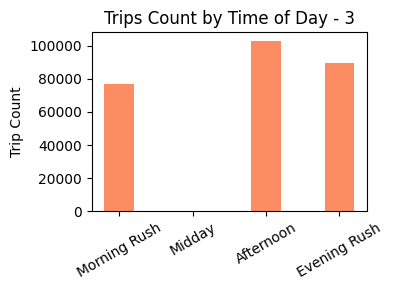

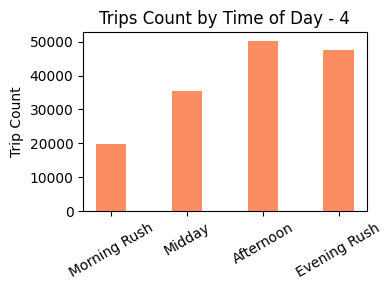

In [ ]:
timeofday('cluster_gmm5')